# Warum Padding wichtig ist

In [22]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
# Für Pynq
from pynq import Overlay
from pynq import allocate
ol = Overlay("Matlab_Filter_v2_18_4.bit")  # max output2^18, dma 2^26 (max), FilterOrder = 4 v.2.2
# Check IP names
ol.ip_dict.keys()

dict_keys(['axi_dma_0', 'BiquadFil_ip_2_2_0', 'processing_system7_0'])

In [23]:
# Zuweisung für dma
dma = ol.axi_dma_0
dma_send = ol.axi_dma_0.sendchannel
dma_recv = ol.axi_dma_0.recvchannel
# check status
print("Error: ", dma_recv.error, "Idle: ", dma_recv.idle, "Running: ", dma_recv.running)
print("Error: ", dma_send.error, "Idle: ", dma_send.idle, "Running: ", dma_send.running)

Error:  False Idle:  False Running:  True
Error:  False Idle:  False Running:  True

In [24]:
# Funktionen
def FormatChange(x):
    x = x * (2**15)                            # Skalieren auf Q16.16 Bereich (optional leicht unter max)
    x = x.astype(np.int32)                     # Als 32-Bit Integer interpretieren
    input_data = x.view(np.uint32)             # Für DMA als unsigned darstellen
    return input_data

4410 4410 <class 'numpy.ndarray'>

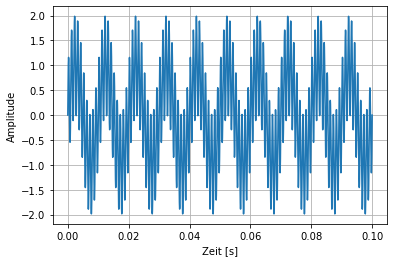

In [43]:
# Generierung Test Signals
sampleRate = 44100
T = 0.1
t = np.linspace(0,T,int(sampleRate*T))
x = np.sin(1000 * 2 * np.pi * t) + np.sin(100 * 2 * np.pi * t)

print(len(t), len(x), type(x))
plt.plot(t,x)
plt.xlabel("Zeit [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [44]:
# Vorbereitung für den Buffer
ip_buffer = 2**18
buffer_size = int(ip_buffer)
print("Buffer Size: ", buffer_size)
input_data = FormatChange(x)
data_size = int(len(input_data)) 

# Padding
pad = np.zeros(ip_buffer)
pad_frame = FormatChange(pad)
print(pad_frame, len(pad_frame), type(pad_frame))

Buffer Size:  262144
[0 0 0 ... 0 0 0] 262144 <class 'numpy.ndarray'>

Beim Erstellen der DMA-Buffer in Python werden diese mit undefinierten
Werten befüllt, die intern als NaN (Not a Number) oder
nicht-initialisierte Daten erscheinen können. Beim Anzeigen per print()
wirken sie zwar wie Nullen, enthalten aber tatsächlich keine gültigen,
interpretierten Werte.<br>

Wenn der Buffer größer ist als die tatsächlich zu übertragenden Daten
und nicht vollständig mit gültigen Werten überschrieben wird, bleiben
diese ungültigen Inhalte im Speicher. Werden diese vom DMA übertragen,
kann dies zu internen Fehlerzuständen führen, wodurch der DMA blockiert
wird und weitere Übertragungen nicht mehr möglich sind.<br>

Um dennoch mit großen DMA-Frames arbeiten zu können, müssen die Buffer
vollständig mit gültigen Daten gefüllt werden.<br>

**Lösung:** Vor der Übertragung wird der gesamte Buffer initial mit
Nullen befüllt (Padding). Anschließend werden die tatsächlichen
Nutzdaten am Anfang des Buffers überschrieben. Dadurch enthält der
komplette Buffer gültige, wohldefinierte Werte, was dem DMA eine
fehlerfreie Übertragung ermöglicht.

In [45]:
# Leere Buffer
input_buffer = allocate(shape=(buffer_size,), dtype=np.uint32)
output_buffer = allocate(shape=(buffer_size,), dtype=np.uint32)
# Padding Inputbuffer
input_buffer[:] = pad_frame
# Laden der Daten in Inputbuffer
input_buffer[: data_size] = input_data
print(input_buffer)

# check status
print("Recv Status: ","Error: ", dma_recv.error, "Idle: ", dma_recv.idle, "Running: ", dma_recv.running)
print("Send Status: ","Error: ", dma_send.error, "Idle: ", dma_send.idle, "Running: ", dma_send.running)

[    0  5120 10147 ...     0     0     0]
Recv Status:  Error:  False Idle:  True Running:  True
Send Status:  Error:  False Idle:  True Running:  True

In [46]:
# Senden un Empfangen der Daten
dma.sendchannel.transfer(input_buffer)
dma.recvchannel.transfer(output_buffer)
dma.sendchannel.wait()
dma.recvchannel.wait()

In [47]:
# Umrechnen der Empfangenen Daten
output_data = np.array(output_buffer[: data_size]).view(np.int32)  # zurück zu signed int32
y = output_data / (2**15)
# check status
print("Recv Status: ","Error: ", dma_recv.error, "Idle: ", dma_recv.idle, "Running: ", dma_recv.running)
print("Send Status: ","Error: ", dma_send.error, "Idle: ", dma_send.idle, "Running: ", dma_send.running)

Recv Status:  Error:  False Idle:  True Running:  True
Send Status:  Error:  False Idle:  True Running:  True

4410

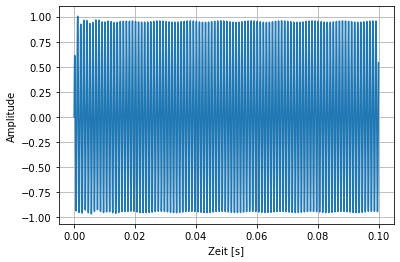

In [48]:
# Empfangene Daten plotten
print(len(y))
plt.plot(t,y)
plt.xlabel("Zeit [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [49]:
# Buffer leeren
del input_buffer, output_buffer
# check status
print("Recv Status: ","Error: ", dma_recv.error, "Idle: ", dma_recv.idle, "Running: ", dma_recv.running)
print("Send Status: ","Error: ", dma_send.error, "Idle: ", dma_send.idle, "Running: ", dma_send.running)

Recv Status:  Error:  False Idle:  True Running:  True
Send Status:  Error:  False Idle:  True Running:  True